<a href="https://colab.research.google.com/github/syedshubha/QNET25_Shubha/blob/main/DenseErrorFull.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --quiet qiskit
%pip install --quiet qiskit-aer
%pip install --quiet pylatexenc
%pip install --quiet qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 35.1 MB/s eta 0:00:00


In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Gate, Parameter
from qutip import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.lines as mlines

from scipy.optimize import minimize
from scipy.linalg import logm, sqrtm
import warnings

<ipython-input-3-bc8ad922e7b3>:63: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  QEC.x(0).c_if(stab_cr, 1)
<ipython-input-3-bc8ad922e7b3>:64: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  QEC.z(1).c_if(stab_cr, 2)


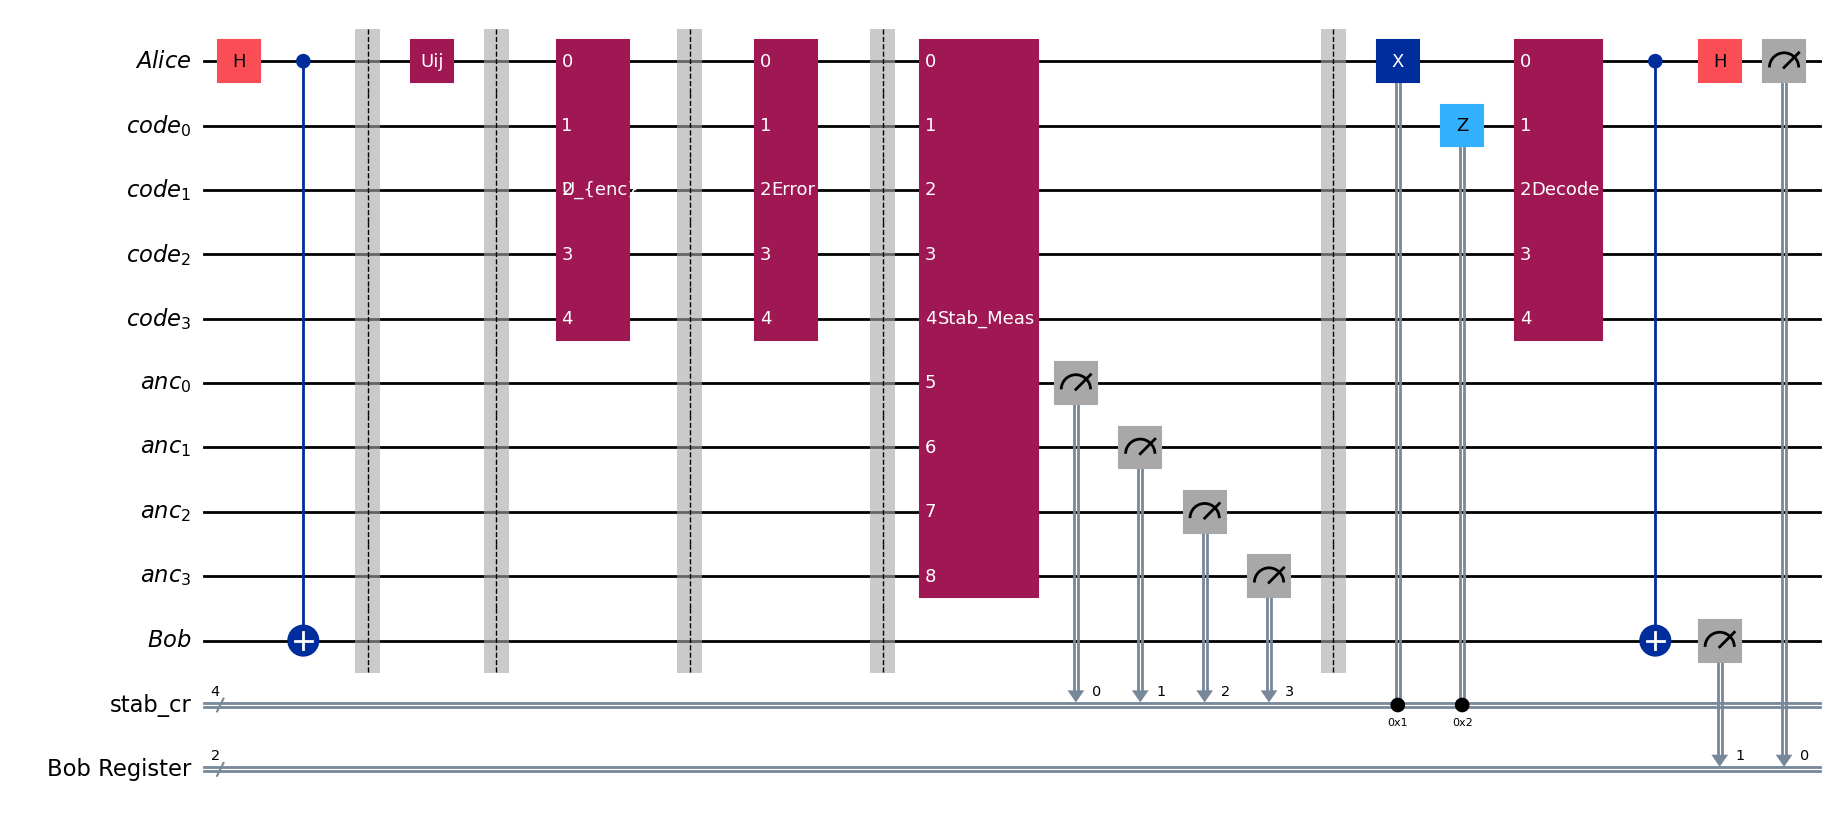

In [3]:
# Define registers
alice = QuantumRegister(1, 'Alice')
code = QuantumRegister(4, 'code')
anc = QuantumRegister(4, 'anc')
bob = QuantumRegister(1, 'Bob')
stab_cr = ClassicalRegister(4, 'stab_cr')
cr = ClassicalRegister(2, 'Bob Register')
QEC = QuantumCircuit(alice, code, anc, bob, stab_cr, cr)

# Define actual sub-circuits
# Encoding
encode_circ = QuantumCircuit(5)
encode_circ.h([2, 3, 4])
encode_circ.cx(0, 1)
encode_circ.cx(0, 2)
encode_circ.cx(1, 3)
encode_circ.cx(2, 4)
encode_circ.cz(0, 3)
encode_circ.cz(0, 4)
encode_gate = encode_circ.to_gate(label='U_{enc}')

# Syndrome measurement
stab_circ = QuantumCircuit(9)
for i, ops in enumerate([
    [(0, 'cx'), (1, 'cz'), (2, 'cz'), (3, 'cx')],  # S1
    [(1, 'cx'), (2, 'cz'), (3, 'cz'), (4, 'cx')],  # S2
    [(0, 'cx'), (2, 'cx'), (3, 'cz'), (4, 'cz')],  # S3
    [(0, 'cz'), (1, 'cx'), (3, 'cx'), (4, 'cz')]   # S4
]):
    stab_circ.h(5 + i)
    for qubit, gate in ops:
        getattr(stab_circ, gate)(5 + i, qubit)
    stab_circ.h(5 + i)
stab_gate = stab_circ.to_gate(label='Stab_Meas')

# Decoding
decode_gate = encode_circ.inverse().to_gate(label='Decode')

# Define U_ij gate (e.g., X as an example)
encode = QuantumCircuit(1)
encode.x(0)  # Could be I, X, Z, or ZX; X chosen arbitrarily
encode = encode.to_gate(label='Uij')

# Error gate (example: X on qubit 1)
error = QuantumCircuit(5)
error.x(1)  # Placeholder; could be any single-qubit error
error = error.to_gate(label='Error')

# Build the circuit
QEC.h(0)
QEC.cx(0, 9)
QEC.barrier()
QEC.append(encode, [0])
QEC.barrier()
QEC.append(encode_gate, [0, 1, 2, 3, 4])
QEC.barrier()
QEC.append(error, [0, 1, 2, 3, 4])
QEC.barrier()
QEC.append(stab_gate, [0, 1, 2, 3, 4, 5, 6, 7, 8])
QEC.measure([5, 6, 7, 8], [0, 1, 2, 3])
QEC.barrier()
# Add example corrections (incomplete table)
QEC.x(0).c_if(stab_cr, 1)
QEC.z(1).c_if(stab_cr, 2)
# ... (add other corrections)
QEC.append(decode_gate, [0, 1, 2, 3, 4])
QEC.cx(0, 9)
QEC.h(0)
QEC.measure([0, 9], [4, 5])

# Draw the circuit
QEC.draw(output='mpl')

In [4]:
def apply_kraus(rho, kraus_list):
    return sum(k * rho * k.dag() for k in kraus_list)

In [6]:
# Define single-qubit operators
I = qeye(2)
X = sigmax()
Z = sigmaz()
H = (X+Z)/np.sqrt(2)
# Encoding unitary
U1 = tensor(I, I, H, H, H)  # H on qubits 2, 3, 4
U2 = cnot(5, control=0, target=1)  # CNOT 0→1
U3 = cnot(5, control=0, target=2)  # CNOT 0→2
U4 = cnot(5, control=1, target=3)  # CNOT 1→3
U5 = cnot(5, control=2, target=4)  # CNOT 2→4
U6 = cz(5, control=0, target=3)    # CZ 0→3
U7 = cz(5, control=0, target=4)    # CZ 0→4

U_enc = U7 * U6 * U5 * U4 * U3 * U2 * U1

# Initial state: |psi> = |+> (for example), tensor |0000>
psi = (basis(2, 0) + basis(2, 1)).unit()  # |+>
state_0 = tensor(psi, basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0))
rho_0 = ket2dm(state_0)

# Encoded state
rho_encoded = U_enc * rho_0 * U_enc.dag()



NameError: name 'cnot' is not defined

In [ ]:
rho_noisy = rho_encoded
for i in range(5):
    kraus_ops = []
    for k in combined_kraus:
        # Tensor with I on all qubits except i
        ops = [I] * 5
        ops[i] = k
        kraus_ops.append(tensor(ops))
    rho_noisy = apply_kraus(rho_noisy, kraus_ops)

In [ ]:
# Syndrome '0000' -> no error
Ps_0000 = Qobj(np.eye(32))  # Simplified; ideally compute all P_s
Es_0000 = tensor(I, I, I, I, I)

# Syndrome for X on qubit 0: '0001'
Ps_0001 = (0.5 * (I + S1)) * (0.5 * (I + S2)) * (0.5 * (I + S3)) * (0.5 * (I - S4))
Es_0001 = tensor(X, I, I, I, I)

# Add more syndromes and corrections as needed
syndromes = {'0000': (Ps_0000, Es_0000), '0001': (Ps_0001, Es_0001)}
# Full implementation would include all 16 syndromes

# Corrected state
rho_corrected = sum(Ps * rho_noisy * Ps * Es.dag() * Ps * rho_noisy * Ps * Es
                    for _, (Ps, Es) in syndromes.items())

In [ ]:
U_dec = U_enc.dag()
rho_decoded = U_dec * rho_corrected * U_dec.dag()

# Trace out qubits 1-4 to get state on qubit 0
rho_final = rho_decoded.ptrace(0)

In [ ]:
# Noise
p, q = 0.1, 0.2
E0_amp = Qobj([[1, 0], [0, np.sqrt(1 - p)]])
E1_amp = Qobj([[0, np.sqrt(p)], [0, 0]])
E0_phase = Qobj([[np.sqrt(q), 0], [0, 0]])
E1_phase = Qobj([[0, 0], [0, np.sqrt(q)]])
E2_phase = Qobj([[np.sqrt(1 - q), 0], [0, np.sqrt(1 - q)]])
combined_kraus = [e_phase * e_amp for e_phase in [E0_phase, E1_phase, E2_phase]
                  for e_amp in [E0_amp, E1_amp]]
rho_noisy = rho_encoded
for i in range(5):
    kraus_ops = [tensor([k if j == i else I for j in range(5)]) for k in combined_kraus]
    rho_noisy = apply_kraus(rho_noisy, kraus_ops)

# Correction (simplified)
S1, S2, S3, S4 = (tensor(X, Z, Z, X, I), tensor(I, X, Z, Z, X),
                  tensor(X, I, X, Z, Z), tensor(Z, X, I, X, Z))
Ps_0000 = Qobj(np.eye(32))  # Placeholder
Es_0000 = tensor(I, I, I, I, I)
Ps_0001 = (0.5 * (I + S1)) * (0.5 * (I + S2)) * (0.5 * (I + S3)) * (0.5 * (I - S4))
Es_0001 = tensor(X, I, I, I, I)
syndromes = {'0000': (Ps_0000, Es_0000), '0001': (Ps_0001, Es_0001)}
rho_corrected = sum(Ps * rho_noisy * Ps * Es.dag() * Ps * rho_noisy * Ps * Es
                    for _, (Ps, Es) in syndromes.items())

# Decoding
U_dec = U_enc.dag()
rho_decoded = U_dec * rho_corrected * U_dec.dag()
rho_final = rho_decoded.ptrace(0)

# Fidelity
rho_initial = ket2dm(psi)
fidelity = (rho_initial * rho_final).tr()
print(f"Fidelity: {fidelity.real}")